本次实验主要是熟悉 bias 和 variance。

给定的数据集被分成了**三部分**（训练集、交叉验证集、测试集），每部分都由$X$、$y$组成，分别表示水平面的变化量和水坝溢出的水的数量。

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
import scipy.optimize as opt

首先，我们将数据读入并进行可视化。

In [38]:
def load_data():
    """
    since the DataFrame has trouble processing the 2d array
    so we have to do some operations
    """
    data = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])

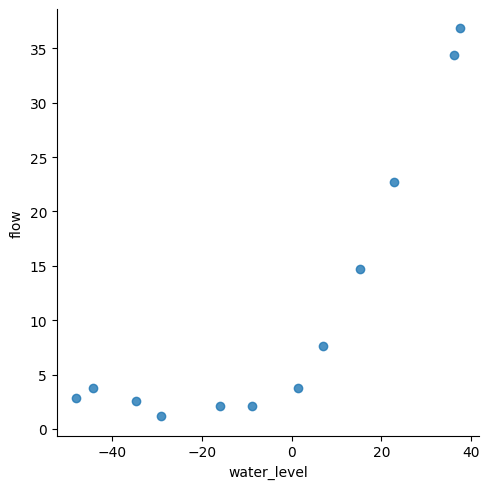

In [39]:
X, y, Xval, yval, Xtest, ytest = load_data()

df = pd.DataFrame({'water_level': X, 'flow':y})
sns.lmplot(x='water_level', y='flow', data=df, fit_reg=False, height=5)
plt.show()

为输入特征添加偏置项

In [40]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

## 代价函数
我们先尝试用线性回归来拟合，其正则化代价函数为：

<img src="img/1.png" width="800" height="150">

In [41]:
def cost(theta, X, y):
    m = X.shape[0]
    return np.power(X @ theta - y, 2).sum() / (2 * m)

def cost_reg(theta, X, y, lamb):
    m = X.shape[0]
    first = np.power(X @ theta - y, 2).sum()
    second = lamb * np.power(theta[1:], 2).sum()
    return (first + second) / (2 * m)

In [42]:
theta = np.ones(X.shape[1])
lamb = 1

cost_reg(theta, X, y, lamb)

303.9931922202643

## 线性回归梯度下降

<img src="img/2.png" width="800" height="200">

In [43]:
def gradient(theta, X, y, lamb):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y) / m
    reg = theta.copy()
    reg[0] = 0 # 不要正则化偏执项
    reg = lamb / m * reg

    return inner + reg

In [44]:
gradient(theta, X, y, lamb)

array([-15.30301567, 598.25074417])

## 拟合数据


我们定义一个训练函数，方便后续根据$m$的变化绘图

In [45]:
def linear_regression_np(X, y, lamb = 1):
    theta = np.ones(X.shape[1])
    res = opt.minimize(fun=cost_reg, x0=theta, args=(X, y, lamb), method='TNC', jac=gradient, options={'disp': True})
    return res

In [46]:
res = linear_regression_np(X, y, lamb)
res

 message: Local minimum reached (|pg| ~= 0)
 success: True
  status: 0
     fun: 22.379541822940265
       x: [ 1.309e+01  3.677e-01]
     nit: 3
     jac: [-2.325e-08 -4.240e-07]
    nfev: 7

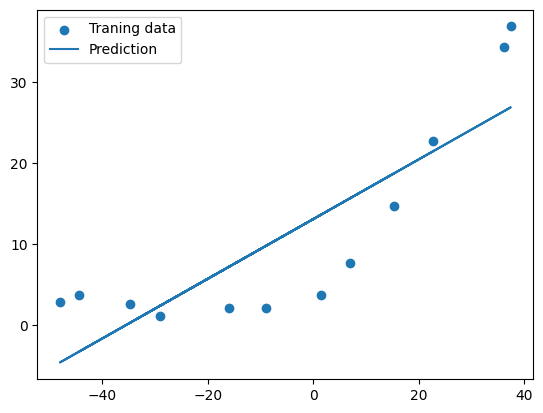

In [47]:
final_theta = res.get('x')

plt.scatter(X[:, 1:], y, label="Traning data")
plt.plot(X[:, 1:], X @ final_theta, label="Prediction")
plt.legend(loc=2)

plt.show()

## 学习曲线

现在我们绘制随着样本数量$m$变化的学习曲线

In [48]:
training_cost, cv_cost = [], []

这里需要注意的是，在计算代价时没有加入正则化

此外，计算训练集代价时要用训练集，计算交叉验证集代价时要用交叉验证集

In [49]:
m = X.shape[0]
for i in range(1, m + 1):
    res = linear_regression_np(X[:i], y[:i], 0)
    tc = cost(res.x, X[:i], y[:i])
    cv = cost(res.x, Xval, yval)
    training_cost.append(tc)
    cv_cost.append(cv)

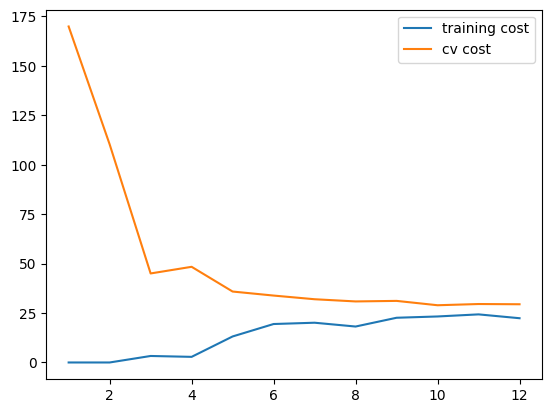

In [50]:
plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

我们可以发现结果与我们课程上的图例非常接近，效果是非常好的。

由于我们只是使用了线性函数来拟合，维数不够，所以有点欠拟合，接下来我们尝试使用多项式来拟合

## 创建多项式特征

下面这个函数是创建各样本的多项式列

In [51]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i) : np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [52]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [53]:
poly_features(X, 3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


对多项式数据进行**标准差标准化**

In [54]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

准备多项式回归数据

In [55]:
def prepare_poly_data(*args, power):
    def prepare(x):
        # expand feature
        df = poly_features(x, power)

        # normalization
        ndarr = normalize_feature(df)

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

In [56]:
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## 画出学习曲线

首先尝试$\lambda=0$，即不添加正则化

In [57]:
def plot_learning_curve(X, y, Xval, yval, lamb=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]
    
    for i in range(1, m + 1):
        # regularize using the first 'i' data
        res = linear_regression_np(X[:i, :], y[:i], lamb)

        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)
    
    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

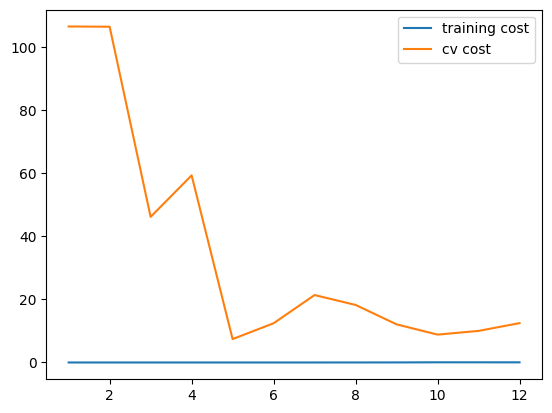

In [58]:
plot_learning_curve(X_poly, y, Xval_poly, yval, 0)
plt.show()

可以看到训练集的代价为零，明显**过拟合**了。

## try $\lambda = 1$

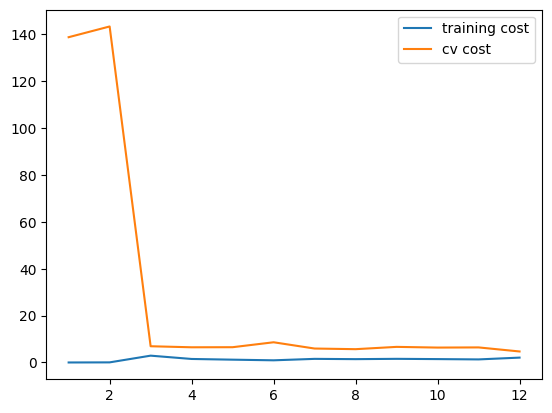

In [59]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lamb=1)
plt.show()

可以看到训练集代价增加了些许，减轻了过拟合的程度

## try $\lambda = 100$

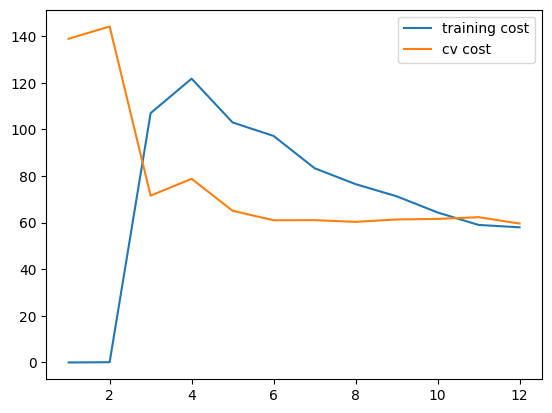

In [60]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lamb=100)
plt.show()

正则化程度太大，造成**欠拟合**

## 寻找最佳的$\lambda$

In [61]:
lamb_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [62]:
for lamb in lamb_candidate:
    res = linear_regression_np(X_poly, y, lamb)

    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)

    training_cost.append(tc)
    cv_cost.append(cv)

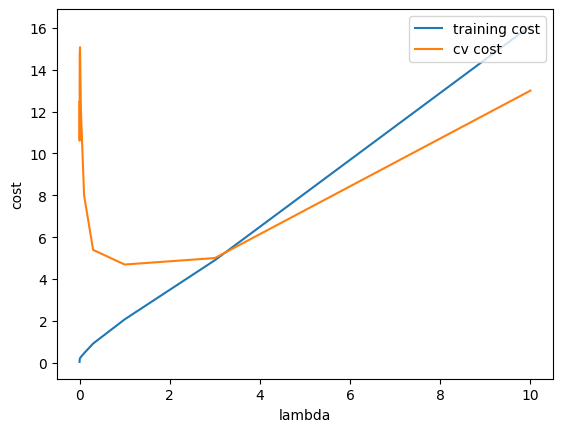

In [63]:
plt.plot(lamb_candidate, training_cost, label='training cost')
plt.plot(lamb_candidate, cv_cost, label='cv cost')
plt.legend(loc=1)

plt.xlabel('lambda')
plt.ylabel('cost')

plt.show()

In [64]:
lamb_candidate[np.argmin(cv_cost)]

1

可以发现当$\lambda=1$时，交叉验证集代价最小

为了验证，我们可以将不同$\lambda$训练出来的模型计算**测试集**的代价

In [70]:
test_cost = []

for lamb in lamb_candidate:
    theta = linear_regression_np(X_poly, y, lamb).x
    tc = cost(theta, Xtest_poly, ytest)
    test_cost.append(tc)
    print('test cost(lamb = {}) = {}'.format(lamb, tc))

test cost(lamb = 0) = 10.055426362410124
test cost(lamb = 0.001) = 11.001927632262907
test cost(lamb = 0.003) = 11.26474655167747
test cost(lamb = 0.01) = 10.880780731411717
test cost(lamb = 0.03) = 10.022100517865269
test cost(lamb = 0.1) = 8.63190793331871
test cost(lamb = 0.3) = 7.3366077892272585
test cost(lamb = 1) = 7.466283751156784
test cost(lamb = 3) = 11.643941860536106
test cost(lamb = 10) = 27.715080254176254


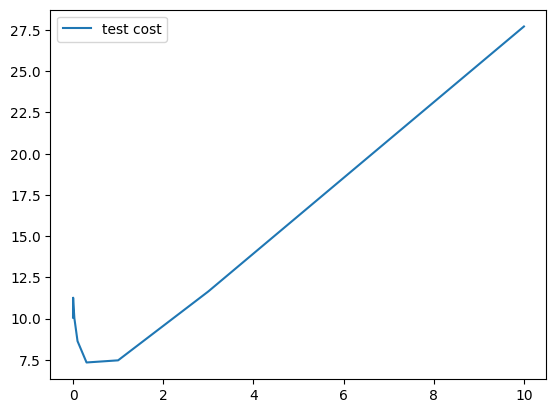

In [71]:
plt.plot(lamb_candidate, test_cost, label='test cost')
plt.legend(loc=2)

plt.show()